In [22]:
import tensorflow as tf
import numpy as np
np.set_printoptions(precision=2)
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Input
from keras import backend as K
from keras.regularizers import l2
import keras
from skimage.transform import rotate
from IPython.display import clear_output

In [3]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")
train_data = mnist.train.images
train_data = train_data.reshape(-1,28,28,1)
train_labels = np.asarray(mnist.train.labels, dtype=np.int32)

Extracting MNIST-data/train-images-idx3-ubyte.gz
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


Эта штука бьёт на пары двойным циклом

In [20]:
def create_train(X, y, z, predictor):
    pairs = []
    
    C0_mask, C1_mask = np.all(y == 0, axis=1), np.all(y == 1, axis=1)        
    C0, C1 = X[C0_mask], X[C1_mask]
    C0_vectors, C1_vectors = predictor(C0), predictor(C1)
    C0, C1, C0_vectors, C1_vectors = list(map(lambda x: list(x), [C0, C1, C0_vectors, C1_vectors]))
        
    z0,z1 = z[C0_mask].reshape(-1), z[C1_mask].reshape(-1)
    z0, z1 = list(z0), list(z1)
        
    while len(C0) > 0 and len(C1) > 0:
        clear_output()
        print(len(C0),' remain')
        x0_index = 0 # будем подбираем пару для нулевого элемента C0
        norm = np.linalg.norm(np.array(C1_vectors) - C0_vectors[0], axis=1)
        x1_index = np.argmin(norm) # ему сгодится такая пара

        new_pair = [C0[x0_index], C1[x1_index]]
        pairs.append(new_pair) # присобачиваем полученную пару к pairs

        del C0[x0_index]
        del C1[x1_index]
        del C0_vectors[x0_index]
        del C1_vectors[x1_index]
        del z0[x0_index]
        del z1[x1_index]
    return pairs

# Определяем Cnn
Второй метод отвечает за пересчёт вероятностей и соответствующих констант

In [5]:
class Cnn(Model):
    def __init__(self):
  
        def weighted_loss(constants):
            def loss(y_true, y_pred):
                return K.mean(constants * K.binary_crossentropy(y_true, y_pred), axis=-1)
            return loss

        main_input = Input(shape=[28,28,1], name='input')
        constants = Input(shape=[1], name='constants')

        x = Conv2D(32, (3, 3), activation='relu')(main_input)
        x = Conv2D(32, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = Conv2D(64, (3, 3), activation='relu')(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(256, activation='relu')(x)
        output = Dense(1, activation='sigmoid', name='output')(x)

        super().__init__(inputs=[main_input, constants], outputs=[output])
        
        self.compile(loss=weighted_loss(constants),
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])
        
        y_ = K.placeholder([None, 1])
        y_pred = self(inputs=[main_input,constants])
        simple_loss = K.binary_crossentropy(output=y_pred, target=y_)
        self.grads = K.function([main_input,constants, y_], K.gradients(simple_loss, self.weights))
        
        self.probs = None
        self.consts = None
        
    def recompute_probs_and_consts(self):

        def get_G(pair):
            def l2_norm_of_list_of_arrays(list_of_arrays):
                output = np.concatenate([elem.flatten() for elem in list_of_arrays])
                output = output.reshape(-1)
                return np.linalg.norm(output)
            
            def grads_on_pair(pair):
                return self.grads([pair.reshape(-1,28,28,1),
                                np.array([1,1]).reshape(-1,1),
                                np.array([0,1]).reshape(-1,1)])
            return l2_norm_of_list_of_arrays(grads_on_pair(pair))

        self.probs = np.array([get_G(pair) + 1e-8 for pair in PAIRS], dtype='float64')
        self.probs = self.probs / self.probs.sum()
        self.probs = np.clip(self.probs, a_min=(1 / len(PAIRS))/50, a_max=(1 / len(PAIRS))*50)
        self.probs = self.probs / self.probs.sum()

        self.consts = (1 / len(PAIRS)) * (1 / self.probs)

# Посмотрим, какие повороты не приводят к недо/переобучению

$\pm 3 \deg$, ничего не выучиваем:

In [9]:
D0 = [rotate(img, np.random.normal(loc=-3, scale=5), order=0) for img in train_data]
D1 = [rotate(img, np.random.normal(loc=3, scale=5) , order=0) for img in train_data]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

In [10]:
cnn_3 = Cnn()
cnn_3.fit([X, np.ones([len(X), 1])], y, epochs=5, validation_split=0.2)

Train on 88000 samples, validate on 22000 samples
Epoch 1/5
88000/88000 [==============================] - 90s 1ms/step - loss: 0.6056 - acc: 0.6645 - val_loss: 0.7109 - val_acc: 0.4922
Epoch 2/5
88000/88000 [==============================] - 90s 1ms/step - loss: 0.5556 - acc: 0.7164 - val_loss: 0.7494 - val_acc: 0.4484
Epoch 3/5
88000/88000 [==============================] - 56s 637us/step - loss: 0.5452 - acc: 0.7261 - val_loss: 0.8323 - val_acc: 0.4314
Epoch 4/5
88000/88000 [==============================] - 78s 885us/step - loss: 0.5390 - acc: 0.7288 - val_loss: 0.7492 - val_acc: 0.4569
Epoch 5/5
88000/88000 [==============================] - 85s 967us/step - loss: 0.5334 - acc: 0.7311 - val_loss: 0.7642 - val_acc: 0.4397


$\pm 5 \deg$, что-то выучиваем:

In [12]:
D0 = [rotate(img, np.random.normal(loc=-5, scale=5), order=0) for img in train_data]
D1 = [rotate(img, np.random.normal(loc=5, scale=5) , order=0) for img in train_data]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

In [13]:
cnn_5 = Cnn()
cnn_5.fit([X, np.ones([len(X), 1])], y, epochs=3, validation_split=0.2)

Train on 88000 samples, validate on 22000 samples
Epoch 1/3
88000/88000 [==============================] - 86s 978us/step - loss: 0.4587 - acc: 0.7720 - val_loss: 0.5346 - val_acc: 0.6780
Epoch 2/3
88000/88000 [==============================] - 86s 978us/step - loss: 0.3869 - acc: 0.8222 - val_loss: 0.5305 - val_acc: 0.6652
Epoch 3/3
88000/88000 [==============================] - 88s 1000us/step - loss: 0.3775 - acc: 0.8266 - val_loss: 0.5541 - val_acc: 0.6668


$\pm 15 \deg$, слишком много всего выучиваем:

In [15]:
D0 = [rotate(img, np.random.normal(loc=-15, scale=5), order=0) for img in train_data]
D1 = [rotate(img, np.random.normal(loc=15, scale=5) , order=0) for img in train_data]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

In [16]:
cnn_15 = Cnn()
cnn_15.fit([X, np.ones([len(X), 1])], y, epochs=3, validation_split=0.2)

Train on 88000 samples, validate on 22000 samples
Epoch 1/3
88000/88000 [==============================] - 87s 988us/step - loss: 0.1072 - acc: 0.9553 - val_loss: 0.0291 - val_acc: 0.9879
Epoch 2/3
88000/88000 [==============================] - 86s 979us/step - loss: 0.0224 - acc: 0.9915 - val_loss: 0.0257 - val_acc: 0.9908
Epoch 3/3
88000/88000 [==============================] - 87s 992us/step - loss: 0.0164 - acc: 0.9936 - val_loss: 0.0181 - val_acc: 0.9916


так что в дальнейшем будем работать с поворотами на $\pm5 \deg$

# Сравним uniform сэмплинг и smart сэмплинг 
Определим два сэмплера для сэмплинга пар:

In [17]:
DATA_SHAPE = [-1, 28, 28, 1]
def generate_uniform(pairs, batch_size=512):
    while True:
        inds = np.random.choice(len(pairs), size=(batch_size,))
        current_x = pairs[inds]
        current_y = np.array([[0,1] for _ in current_x])
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y = current_y.reshape(-1,1)
        yield {'input':current_x, 'constants':np.ones(current_y.shape)}, {'output':current_y}

def generate_smart(pairs, probs, consts, batch_size=512):
    while True:
        inds = np.random.choice(len(pairs), size=[batch_size], p=probs)
        current_x = pairs[inds]
        current_y_ = np.array([[0,1] for _ in current_x])
        current_c = np.array([[consts[i], consts[i]] for i in range(len(pairs))])[inds]
        current_x = current_x.reshape(*DATA_SHAPE)
        current_y_ = current_y_.reshape(-1,1)
        current_c = current_c.reshape(-1,1)
        yield {'input':current_x, 'constants':current_c}, {'output':current_y_}

датасет для сравнения ($30*2$к картинок)

In [ ]:
D0 = [rotate(img, np.random.normal(loc=-5, scale=5), order=0) for img in train_data[:30000]]
D1 = [rotate(img, np.random.normal(loc=5, scale=5) , order=0) for img in train_data[:30000]]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

# Наконец побьём на пары:
PAIRS = create_train(X, y , np.ones(len(y)), lambda x: x.reshape(-1,28*28))
PAIRS = np.array(PAIRS)

1  remain


In [25]:
cnn_uniform = Cnn()
cnn_uniform.save_weights('weights')
cnn_smart = Cnn()
cnn_smart.load_weights('weights')

Будем измерять лосс на трейне

In [ ]:
uniform_losses = []
for _ in range(50):
    clear_output()
    print(_)
    cnn_uniform.fit_generator(generate_uniform(PAIRS, batch_size=64),
                            steps_per_epoch=100, epochs=1, verbose=False)
    loss = cnn_uniform.evaluate([X, np.ones([len(X),1])], y, batch_size=128, verbose=False)[0]
    uniform_losses.append(loss)
    
    
smart_losses = []    
for _ in range(50):
    clear_output()
    print(_)
    if _ < 10:
        cnn_smart.fit_generator(generate_uniform(PAIRS, batch_size=64),
                            steps_per_epoch=100, epochs=1, verbose=False)
    else:
        if _ % 5 == 0:cnn_smart.recompute_probs_and_consts()
        cnn_smart.fit_generator(generate_smart(PAIRS, cnn_smart.probs, cnn_smart.consts, batch_size=64),
                                steps_per_epoch=100, epochs=1, verbose=False)    
    loss = cnn_smart.evaluate([X, np.ones([len(X),1])], y, batch_size=128, verbose=False)[0]
    smart_losses.append(loss)

49


Не наблюдаем преимуществ:

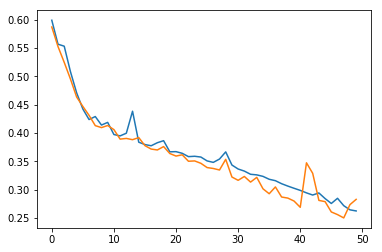

In [27]:
plt.plot(uniform_losses)
plt.plot(smart_losses)
plt.show()

# Проверим, как влияет на переобучение софтплюс+l2рег

In [42]:
class Cnn_softplus(Model):
    def __init__(self):
  
        def weighted_loss(constants):
            def loss(y_true, y_pred):
                return K.mean(constants * K.binary_crossentropy(y_true, y_pred), axis=-1)
            return loss

        main_input = Input(shape=[28,28,1], name='input')
        constants = Input(shape=[1], name='constants')

        x = Conv2D(32, (3, 3), activation='softplus', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(main_input)
        x = Conv2D(32, (3, 3), activation='softplus', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
        x = MaxPooling2D((2, 2))(x)
        x = Conv2D(64, (3, 3), activation='softplus', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
        x = Conv2D(64, (3, 3), activation='softplus', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
        x = MaxPooling2D((2, 2))(x)
        x = Flatten()(x)
        x = Dense(256, activation='softplus', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)
        output = Dense(1, activation='sigmoid', name='output', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))(x)

        super().__init__(inputs=[main_input, constants], outputs=[output])
        
        self.compile(loss=weighted_loss(constants),
                      optimizer=keras.optimizers.Adam(),
                      metrics=['accuracy'])
        
        y_ = K.placeholder([None, 1])
        y_pred = self(inputs=[main_input,constants])
        simple_loss = K.binary_crossentropy(output=y_pred, target=y_)
        self.grads = K.function([main_input,constants, y_], K.gradients(simple_loss, self.weights))
        
        self.probs = None
        self.consts = None
        
    def recompute_probs_and_consts(self):

        def get_G(pair):
            def l2_norm_of_list_of_arrays(list_of_arrays):
                output = np.concatenate([elem.flatten() for elem in list_of_arrays])
                output = output.reshape(-1)
                return np.linalg.norm(output)
            
            def grads_on_pair(pair):
                return self.grads([pair.reshape(-1,28,28,1),
                                np.array([1,1]).reshape(-1,1),
                                np.array([0,1]).reshape(-1,1)])
            return l2_norm_of_list_of_arrays(grads_on_pair(pair))

        self.probs = np.array([get_G(pair) + 1e-8 for pair in PAIRS], dtype='float64')
        self.probs = self.probs / self.probs.sum()
        self.probs = np.clip(self.probs, a_min=(1 / len(PAIRS))/50, a_max=(1 / len(PAIRS))*50)
        self.probs = self.probs / self.probs.sum()

        self.consts = (1 / len(PAIRS)) * (1 / self.probs)

$\pm 3 \deg$, оверфит никуда не исчез

In [43]:
D0 = [rotate(img, np.random.normal(loc=-3, scale=5), order=0) for img in train_data]
D1 = [rotate(img, np.random.normal(loc=3, scale=5) , order=0) for img in train_data]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

In [44]:
cnn_softplus_3 = Cnn_softplus()
cnn_softplus_3.fit([X, np.ones([len(X), 1])], y, epochs=3, validation_split=0.2)

Train on 88000 samples, validate on 22000 samples
Epoch 1/3
88000/88000 [==============================] - 54s 612us/step - loss: 0.8294 - acc: 0.6224 - val_loss: 0.8999 - val_acc: 0.0000e+00
Epoch 2/3
88000/88000 [==============================] - 51s 576us/step - loss: 0.6724 - acc: 0.6246 - val_loss: 0.9583 - val_acc: 0.0000e+00
Epoch 3/3
88000/88000 [==============================] - 53s 600us/step - loss: 0.6684 - acc: 0.6250 - val_loss: 0.9809 - val_acc: 0.0000e+00


$\pm 5 \deg$, оверфит никуда не исчез

In [45]:
D0 = [rotate(img, np.random.normal(loc=-5, scale=5), order=0) for img in train_data]
D1 = [rotate(img, np.random.normal(loc=5, scale=5) , order=0) for img in train_data]
X = np.append(D0, D1, axis=0)
y = np.append( np.zeros([len(D0),1]), np.ones([len(D1),1]), axis=0)

In [46]:
cnn_softplus_5 = Cnn_softplus()
cnn_softplus_5.fit([X, np.ones([len(X), 1])], y, epochs=3, validation_split=0.2)

Train on 88000 samples, validate on 22000 samples
Epoch 1/3
88000/88000 [==============================] - 54s 616us/step - loss: 0.8163 - acc: 0.6232 - val_loss: 1.2001 - val_acc: 0.0000e+00
Epoch 2/3
88000/88000 [==============================] - 52s 590us/step - loss: 0.6708 - acc: 0.6250 - val_loss: 1.0481 - val_acc: 0.0000e+00
Epoch 3/3
88000/88000 [==============================] - 50s 569us/step - loss: 0.6681 - acc: 0.6250 - val_loss: 1.0190 - val_acc: 0.0000e+00
